<a href="https://colab.research.google.com/github/bluehood/GPT-Implementation/blob/main/GPT_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic GPT Implementation
The Generative Pre-trained Transformer (GPT) represents a monumental advancement in natural language processing, first introduced by Radford et al. in their seminal 2018 paper "Improving Language Understanding by Generative Pre-Training". At its core, GPT is an autoregressive language model based on the transformer architecture, specifically using the decoder portion of the transformer. The model learns to predict the next token in a sequence given all previous tokens, enabling it to generate coherent and contextually relevant
text.

In this implementation, we'll create a small version of the GPT architecture, maintaining its core components while scaling down the model size for practical training. Our implementation includes the essential elements: token and positional embeddings, multi-head self-attention mechanisms, feed-forward networks, and layer normalization. We'll train this model on a modest dataset, a copy of 'Alice and Wonderland', to demonstrate the fundamental principles of how GPT models learn to generate text. We'll also focus on the pre-training stage rather than fine-tuning the model for a specific downstream task, as fine-tuning requires high-quality labelled datasets.

Through this implementation, we'll explore how these models process text, learn patterns, and generate new content, providing hands-on experience with one of the most influential architectures in modern natural language processing. We'll discuss how the architecture works alongside our implementation in Pytorch, which should provide a detailed understanding of how the model functions.

## Disclaimer
The purpose of the notebook is to implement the GPT architecture, discuss how the model functions and to understand the Pytorch implementation. This notebook is not designed to be used to train your own GPT model (although it could be modified to do this). If you want to train the full model please see the training details in the following repository: https://github.com/bluehood/GPT-Implementation.

# Model Architecture Overview

The model architecture can be roughly split into three phases:
- Data preparation: tokenisation, embeddings and positional encodings.
- Enrichment: the main transformer blocks consist of multi-headed attention and feed-forward layers.
- Prediction: feed-forward layer combined with the softmax function for next token prediction.

The following diagram gives an overview of the structure of the model.

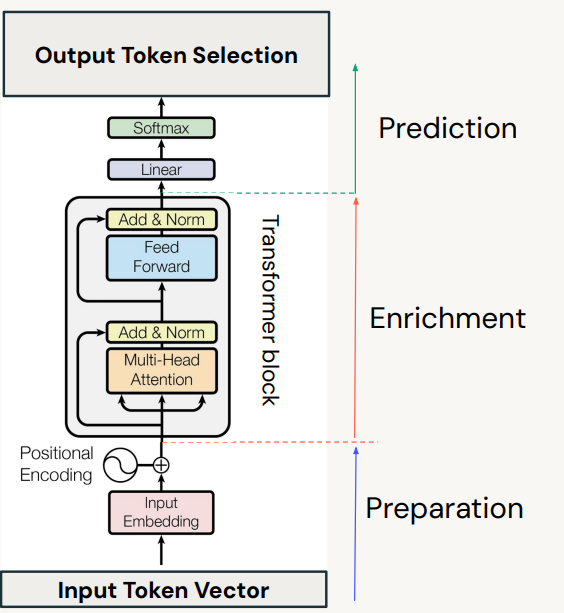

Image from https://medium.com/@akriti.upadhyay/building-custom-gpt-with-pytorch-59e5ba8102d4

## Tokenisation
The first step of the process is to convert our corpus of text data into a usable form using our model. Our model can only process numerical data - therefore we need to translate our text data into numerical data. This is the task of tokenisation, where text data is converted to a set of numerical tokens that can then be fed into the transformer. There are several different types of tokenisation that can be implemented:

- Word-level Tokenisation splits text at word boundaries, treating each word as a distinct token. For example, `"The cat sat"` becomes `["The", "cat", "sat"]`.

- Character-level Tokenisation breaks text into individual characters, so `"The cat"` becomes `["T", "h", "e", " ", "c", "a", "t"]`.

- Subword-level Tokenisation represents a middle ground, breaking words into meaningful subunits. Common words remain whole tokens, while rarer words are split into subwords. For example, `"unrealistic"` might become `["un", "real", "istic"]`.

Typically, Subword-level tokenisation is the preferred method for tokenisation in modern GPT architectures. It can handle rare words and even misspellings by combining subword units. However, to simplify the tokenisation process, we will use Word-level tokenisation in this work.

## Embeddings
Next, an embedding layer is implemented, which converts input tokens into vector representations. These embeddings can be thought of as learning the basic semantic properties of each token in our vocabulary. In particular, words that have a similar semantic meaning will be closer together in the vector space; conversely, unrelated words will be further apart. However, since language depends heavily on word order and context, we also add positional embeddings. These positional embeddings allow the model to understand where each token appears in the sequence.

## Transformer Blocks
The core of the GPT architecture consists of multiple transformer blocks, each containing two main sublayers: multi-head self-attention and a position-wise feed-forward network. The self-attention mechanism is particularly fascinating as it allows the model to weigh the importance of different parts of the input sequence when processing each token. For example, in the sentence `"The trophy doesn't fit in the brown suitcase because it's too big,"` the attention mechanism helps the model understand that `"it"` refers to `"the trophy"` rather than `"the suitcase"` by learning to attend more strongly to relevant previous tokens.

Multi-head attention takes this concept further by allowing the model to attend to different aspects of the input simultaneously. The model might simultaneously track grammatical structure, semantic meaning, and contextual references. Each attention head can specialize in capturing different types of relationships: some heads might focus on adjacent words, others on long-range dependencies, and still others on specific linguistic patterns. In practice it is difficult to understand the relationships that each attention head captures; it is likely to be a combination of all relationships bundled together.

The position-wise feed-forward network that follows each attention layer adds another level of transformation. This fully connected layer processes each position independently but identically, allowing the model to apply the same learned transformations to each position in the sequence. This component can be thought of as giving the model the capacity to reason about the features extracted by the attention mechanism.

Layer normalization and residual connections play crucial roles in stabilizing the network and allowing for effective training of deep architectures. Layer normalization helps maintain consistent scales of activations throughout the network, while residual connections provide direct pathways for information flow and help combat the vanishing gradient problem in deep networks.

## Output
The final layer of the model projects the transformed representations back into our vocabulary space, producing logits that represent the model's predictions for the next token in the sequence. During training, these predictions are compared against the actual next tokens, and the model learns to minimise this prediction error through backpropagation.

# Tokenisation
We will implement Word-level tokenisation, where each word in the text corpus will be translated into its own token. This approach has its drawbacks; it struggles with rare words and requires a large vocabulary to cover most words in a language. Additionally, it cannot handle unseen words well, often replacing them with an `<UNK>` (unknown) token, which loses potentially important information. In practise a more sophisticated approach would be to use Subword-level tokenisation (but we're keeping it simpler here).

The first process in tokenisation is to load and clean the dataset. We'll remove unwanted characters whilst retaining alphanumeric characters and punctuation from the dataset. We'll also process the dataset as lowercase characters to simplify the grammatical meaning in the dataset.

In [ ]:
from collections import defaultdict
import re
import json

def clean_dataset(dataset):
    dataset = dataset.lower()
    dataset = re.sub(r'\n', ' ', dataset)
    dataset = re.sub(r'[^a-z0-9.,!?;\'\" ]', ' ', dataset)
    return dataset

Next, we need to write a method to return a list of words from the dataset. This will process the text data, extract all words, and return them as a list. We'd also like this method to process relevant punctuation as their tokens.

In [ ]:
def basic_tokenize(text):
    # Convert all text to lowercase to standardise tokens
    # This ensures "The" and "the" are treated as the same token
    text = text.lower()

    # Replace all newline characters with spaces
    # This converts multi-line text into a single continuous line
    text = re.sub(r'\n', ' ', text)

    # Add spaces around punctuation marks to treat them as separate tokens
    # For example: "hello,world" becomes "hello , world"
    # This allows the model to learn punctuation patterns independently
    text = re.sub(r'([.,!?;])', r' \1 ', text)

    # Add spaces around quotation marks to treat them as separate tokens
    # For example: 'he said"hello"' becomes 'he said " hello "'
    text = re.sub(r'(["\'])', r' \1 ', text)

    # Remove all characters that aren't lowercase letters, numbers,
    # or specified punctuation marks, replacing them with spaces
    # This cleans the text of special characters, symbols, and other noise
    text = re.sub(r'[^a-z0-9.,!?;\'\" ]', ' ', text)

    # Replace any sequence of multiple spaces with a single space
    # This cleans up the extra spaces created by previous operations
    text = re.sub(r'\s+', ' ', text)

    # Remove any leading or trailing spaces from the text
    # This ensures clean token boundaries at the start and end
    text = text.strip()

    # Split the text into tokens at space boundaries
    # This creates our final list of tokens for processing
    tokens = text.split()

    return tokens

Now we need to create our vocabulary which will map all words in the text corpus to a numerical token (and vice versa). We'll also start with four special tokens:
- `<PAD>`: a padding token which does nothing but pads out a sentence.
- `<UNK>`: an unknown token, representing a token that is not found in our vocabulary.
- `<START>`: represents the start of a sequence.
- `<END>`: represents the end of a sequence.

The `<START>` and `<END>` tokens are more relevant in the fine-tuning of a GPT, where you might like the model to start or stop generating text.

In [ ]:
def create_vocabulary(tokens, min_frequency=2):
    # Initialize a defaultdict to count token occurrences
    token_counts = defaultdict(int)

    # Count the frequency of each token in our dataset
    # This helps us understand which tokens are common enough to include
    for token in tokens:
        token_counts[token] += 1

    # Initialize our vocabulary with special tokens
    vocab = {
        '<PAD>': 0,
        '<UNK>': 1,
        '<START>': 2,
        '<END>': 3,
    }

    # Start numbering regular tokens after our special tokens
    token_idx = len(vocab)

    # Iterate through our token counts and add frequent tokens to vocabulary
    # We only add tokens that appear at least min_frequency times
    # This helps reduce vocabulary size by excluding rare words
    for token, count in token_counts.items():
        if count >= min_frequency:
            vocab[token] = token_idx
            token_idx += 1

    return vocab

We can now load our text corpus and create our tokeniser. As mentioned previously we'll be using a copy of Alice in Wonderland to train this model as a simple example, but you could choose a larger corpus if you wanted.

In [ ]:
def save_tokeniser(vocab, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(vocab, f, ensure_ascii=False, indent=2)

with open("./datasets/alice_in_wonderland.txt", "r") as f:
        dataset = f.read()

dataset = clean_dataset(dataset)
tokens = basic_tokenize(dataset)
vocab = create_vocabulary(tokens)
save_tokeniser(vocab, "./models/alice_in_wonderland_tokeniser.json")

We can take a look at our tokeniser. It's a simple JSON object that maps the words (and punctuation) in our corpus to a numerical token.

```json
{
  "<PAD>": 0,
  "<UNK>": 1,
  "<START>": 2,
  "<END>": 3,
  "chapter": 4,
  "i": 5,
  ".": 6,
  "down": 7,
  "the": 8,
  "rabbit": 9,
  "hole": 10,
  "alice": 11,
  "was": 12,
  "beginning": 13,
...
}
```

# GPT Model
There are a few different steps we need to take to create the transformer model. We'll begin by defining the core components: multi-headed self-attention and the feed-forward layers, which will make up the transformer blocks, the embeddings and positional encodings and lastly mapping back to the vocabulary space.

We'll analyse the GPT architecture in sequence in the direction that information flows through the network.

## Embeddings and Positional Encodings
Embeddings and Positional Encoding prepare our dataset for use in the rest of the network. They essentially encode our dataset into a form that can be understood by the Transformer Blocks.

Embeddings translate each token in our sequence into a vector in a vector space, where the vector captures the meaning of the individual token (word). Unlike a regular dictionary that might give you a definition, these vectors are learned during training so that words with similar meanings end up with similar number patterns. For example, the words `king` and `queen` might have similar vectors because they share many contextual patterns, while `bicycle` would have a very different vector.

Embedding is handled by an embedding layer. This creates a lookup table where each word in our vocabulary gets assigned a vector of size n_embd. When we feed in a word, this layer converts it from a simple index number into a rich vector representation that captures semantic meaning.

```python
self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
```

However, embeddings alone are not enough. The order of words matters tremendously in language/ This is where positional encodings come in. They add information about where each word appears in the sequence.

In several GPT implementations, positional encodings use sine and cosine functions of different frequencies to create vectors representing different positions in the sequence. In this implementation, our positional embeddings are learned parameters that get added to the word embeddings. For each position in the sequence, we learn a unique vector that gets combined with the word embedding at that position. This way, the same word will have slightly different representations depending on where it appears in the sequence.

```python
self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
```


## Transformer Blocks

### Multi-Headed Self Attention

Self-attention is about letting each word in a sequence understand its relationship to every other word. Imagine you're reading the sentence `"The cat sat on the mat because it was tired."` To understand what `"it"` refers to, you need to pay attention to earlier words in the sentence. Self-attention allows the model to do exactly this - it learns which words to pay attention to when processing each word in the sequence.

First, for each word position, we create three vectors: a Query (`Q`), a Key (`K`), and a Value (`V`). Think of this like a question-answering system:

- The Query is like asking "What information do I need?".
- The Key is like a label for what information each word contains.
- The Value is the actual information content of each word.

To calculate attention scores, we take the Query for our current word and compare it with the Keys of all words (including itself). This comparison is done through a dot product, which gives us a score indicating how relevant each word is to our current position. We then scale these scores by dividing them by the square root of the dimension of our Key vectors (this helps keep the gradients stable during training).

This can be implemented in Pytorch using matrix multiplication (the Queries, Keys and Values and concatenated together into matrices for easier processing).

```python
# For each attention head, create query, key, and value vectors through learned linear projections
# These projections help each head learn different aspects of the relationships between words
q = self.query_projs[head](x)  # Query: "What information am I looking for?"
k = self.key_projs[head](x)    # Key: "What information do I contain?"
v = self.value_projs[head](x)  # Value: "What information do I provide?"

# Calculate attention scores between all pairs of positions
# The matrix multiplication (q @ k.transpose) computes how relevant each position is to every other position
# We scale by 1/sqrt(d_k) to prevent the dot products from growing too large in magnitude
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.n_embd))

# Apply causal mask to ensure each position can only attend to previous positions
# The mask is a lower triangular matrix where 1s allow attention and 0s block it
# Setting attention scores to -inf ensures they become 0 after softmax
att = att.masked_fill(self.mask[:T, :T] == 0, float('-inf'))

# Convert attention scores to probabilities using softmax
# This ensures all attention weights for each query sum to 1
# The dim=-1 parameter means we normalize across the key dimension
att = F.softmax(att, dim=-1)

# Apply dropout to attention weights for regularization
# This helps prevent the model from becoming too dependent on any single attention pattern
att = F.dropout(att, p=self.dropout, training=self.training)

# Use attention weights to create weighted sum of values
# This combines information from all positions based on their relevance
head_output = att @ v

# Store this head's output for later concatenation with other heads
head_outputs.append(head_output)
```

In GPT models specifically, we use masked self-attention, where each position can only attend to previous positions (and itself). This masking is crucial because it ensures the model can only use the previous context when making predictions, which is essential for our language modelling task (predicting the next word). This stops the model from "cheating" by looking forward in the sequence when it should not be able to.

We've also implemented a softmax function, which normalises the attention weights to sum to one, essentially mapping them to a well-defined probability distribution.

Now, what makes this "multi-headed" is that we do this attention process multiple times in parallel, with different learned projections for `Q`, `K`, and `V` each time. Each "head" can learn to focus on different types of relationships:

- One head might learn to focus on subject-verb relationships.
- Another might learn to track pronoun references.
- A third might focus on temporal relationships between events.

Each head is trained to focus on different aspects of language. When they combine their insights, we get a richer understanding of the text.

To summarise, the attension score of the Query, Key and Value matricies are caculated using: 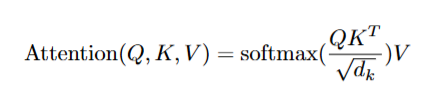

Where `d_k` is the dimension of the key vectors.

The attention scores calculated over each head are concatenated together and passed to the rest of the network.

In Pytorch, we implement the multi-headed attention mechanism in the following way:

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Store configuration parameters that define the attention mechanism's structure
        self.num_heads = config.num_heads  # Number of parallel attention heads
        self.n_embd = config.n_embd       # Size of embedding dimension
        self.dropout = config.dropout      # Dropout rate for regularization

        # Create separate projection layers for each attention head
        # Each head gets its own set of query, key, and value projections
        # This allows each head to focus on different aspects of the input
        self.query_projs = nn.ModuleList([
            nn.Linear(config.n_embd, config.n_embd) for _ in range(config.num_heads)
        ])
        self.key_projs = nn.ModuleList([
            nn.Linear(config.n_embd, config.n_embd) for _ in range(config.num_heads)
        ])
        self.value_projs = nn.ModuleList([
            nn.Linear(config.n_embd, config.n_embd) for _ in range(config.num_heads)
        ])

        # Final projection layer to combine outputs from all heads
        # Input dimension is n_embd * num_heads because we concatenate all head outputs
        # Output dimension is n_embd to maintain the model's dimension
        self.proj = nn.Linear(config.n_embd * config.num_heads, config.n_embd)

        # Create the causal mask for autoregressive attention
        # torch.tril creates a lower triangular matrix of ones
        # This mask ensures each position can only attend to previous positions
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size)))

    def forward(self, x):
        # Extract batch size (B), sequence length (T), and embedding dimension (C)
        B, T, C = x.size()

        # Process each attention head separately
        head_outputs = []
        for head in range(self.num_heads):
            # Project input into query, key, and value vectors for this head
            q = self.query_projs[head](x)
            k = self.key_projs[head](x)
            v = self.value_projs[head](x)

            # Compute attention scores and apply them to values
            # The scaling factor 1/sqrt(n_embd) prevents dot products from growing too large
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.n_embd))
            # Apply causal mask to prevent attending to future positions
            att = att.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
            # Convert scores to probabilities with softmax
            att = F.softmax(att, dim=-1)
            # Apply dropout for regularization
            att = F.dropout(att, p=self.dropout, training=self.training)
            # Compute weighted sum of values based on attention scores
            head_output = att @ v
            head_outputs.append(head_output)

        # Concatenate outputs from all heads along the embedding dimension
        multi_head_output = torch.cat(head_outputs, dim=-1)

        # Project concatenated outputs back to original embedding dimension
        y = self.proj(multi_head_output)
        return y

### Feed-Forward Layers
The feed-forward network in a transformer block comes after the multi-headed self-attention layer and serves a fundamentally different but complementary purpose. While self-attention helps the model understand relationships between different positions in the sequence, the feed-forward network processes each position independently, applying the same transformation to each one. This allows the model to process the information gathered by attention and make position-specific decisions.

The feed-forward uses what's called an "expansion and projection" pattern. The first linear layer expands the dimensionality of the input, and the last layer projects it back down to the original dimension. This expansion gives the network more capacity to process information.

Between these linear layers, we have a non-linear activation function, GELU (Gaussian Error Linear Unit). This non-linearity is crucial because it allows the network to learn complex patterns that cannot be captured by linear transformations alone. GELU is particularly effective because it provides smooth gradients and has properties that make it well-suited for deep learning.

In practice, these feed-forward networks are often one of the most parameter-heavy parts of transformer models, but this capacity is crucial for the model's ability to learn complex patterns in language. They provide the model with the computational depth needed to process the rich contextual information gathered by the attention mechanisms.

Here's an implementation of the feed-forward layers of a GPT in Pytorch:

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            # First layer expands the dimension by a factor of 4
            nn.Linear(config.n_embd, 4 * config.n_embd),
            # Non-linear activation function
            nn.GELU(),
            # Second layer projects back to original dimension
            nn.Linear(4 * config.n_embd, config.n_embd),
            # Dropout for regularization
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

### Transformer Blocks
A Transformer block represents a complete processing unit in the GPT architecture. This consists of our multi-headed self-attention and feedforward layers, complimented with layer normalisation to ensure that our data is appropriately normalised as it flows through the model, allowing the model to train in a stable manner.

Each block contains the following steps:
- Multi-headed self-attention.
- Layer normalisation.
- Feedforward layer.
- Layer normalisation.

Each also adds residual connections bypassing the attention and feed-forward layers. This helps information flow through the network and prevents the vanishing gradient problem, whereby parameters at the start of the model do not update as the gradient is near zero by the time backpropagation reaches them.

The first sub-block (self-attention) helps the model understand relationships between different parts of the text. The layer normalization first stabilises the representations, making them easier to process. Then the attention mechanism helps each position gather relevant information from other positions. The residual connection ensures that no important information is lost during this process. The second sub-block (feed-forward) processes this contextual information further.

In [ ]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        # First layer normalisation
        # This normalises inputs before attention to stabilise training
        # Think of it like standardising data before processing
        self.ln1 = nn.LayerNorm(config.n_embd)

        # Multi-head self-attention layer
        # This allows the model to weigh the importance of different words
        # for understanding each position in the sequence
        self.attn = MultiHeadAttention(config)

        # Second layer normalization
        # Similar to ln1, but prepares data for the feed-forward network
        # This helps maintain stable gradients through deep networks
        self.ln2 = nn.LayerNorm(config.n_embd)

        # Position-wise feed-forward network
        # This processes the attention-weighted information at each position
        # independently, allowing for complex transformations of the data
        self.ffwd = FeedForward(config)

    def forward(self, x):
        # First sub-block: Attention with residual connection
        # 1. Normalize the input (ln1)
        # 2. Apply attention (attn)
        # 3. Add the result back to the input (residual connection)
        # This creates a path for information to flow directly through the network
        x = x + self.attn(self.ln1(x))

        # Second sub-block: Feed-forward with residual connection
        # 1. Normalize the attention output (ln2)
        # 2. Apply feed-forward transformation (ffwd)
        # 3. Add the result back to the previous output (residual connection)
        x = x + self.ffwd(self.ln2(x))

        return x

## Output Linear Layer
At this point, we have a high-dimensional representation of the text input into the model. However, we need to map back to the tokens to predict the next word in the sequence.

The linear layer performs a matrix multiplication that maps these high-dimensional representations back to a vector with the size of our vocabulary.

```python
self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
```

We implement a linear layer which maps from the embedding size to the vocabulary size. Each number in this final vector represents a score for each word in our vocabulary - the higher the score, the more likely the model thinks that word should come next. These scores (logits) then get transformed into probabilities through a softmax function when we want to actually generate text.

```python
logits = logits[:, -1, :] / temperature  # Get predictions for next token
probs = F.softmax(logits, dim=-1)  # Convert to probabilities
next_token = torch.multinomial(probs, num_samples=1)  # Sample next token
```
The temperature parameter here controls how "creative" or "conservative" the model's predictions are - lower temperatures make the model more likely to pick the highest-scoring word, while higher temperatures make it more likely to try different options.


## Putting it Together
Now we have defined the building blocks we can create the full model:

In [ ]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Store configuration parameters for easy access throughout the model
        self.config = config

        # Token embedding layer converts word indices into dense vectors
        # For each word in our vocabulary (config.vocab_size), create a vector
        # of size config.n_embd that represents its meaning
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)

        # Learnable positional embeddings help model understand word order
        # Shape is (1, block_size, n_embd) - one vector per position
        # These get added to token embeddings to encode position information
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))

        # Dropout layer for regularisation - randomly zeros out some values
        # during training to prevent overfitting
        self.drop = nn.Dropout(config.dropout)

        # Create a stack of transformer blocks
        # Each block contains self-attention and feed-forward layers
        # config.n_layer determines how deep our network is
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])

        # Final layer normalisation to stabilize outputs
        self.ln_f = nn.LayerNorm(config.n_embd)

        # Output projection layer maps from model dimension back to vocabulary size
        # This lets us score each possible next word in our vocabulary
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        # Get batch size (B) and sequence length (T) from input
        B, T = idx.size()

        # Ensure sequence isn't longer than what our positional embeddings can handle
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"

        # Convert input token indices into embeddings
        tok_emb = self.tok_emb(idx)

        # Get positional embeddings for this sequence length
        # and add them to token embeddings
        pos_emb = self.pos_emb[:, :T, :]
        x = self.drop(tok_emb + pos_emb)

        # Pass the embeddings through each transformer block in sequence
        # Each block refines our understanding of the text
        for block in self.blocks:
            x = block(x)

        # Apply final layer normalization
        x = self.ln_f(x)

        # Project to vocabulary size to get next-token predictions
        logits = self.head(x)

        # If targets are provided (during training), compute loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Text generation function that autoregressively generates new tokens.
        - idx: Starting sequence of tokens
        - max_new_tokens: How many new tokens to generate
        - temperature: Controls randomness (lower = more deterministic)
        - top_k: If set, only sample from k most likely tokens
        """
        for _ in range(max_new_tokens):
            # Get predictions for next token using the most recent context
            # If context is too long, use only the last block_size tokens
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

            # Get predictions from model
            logits, _ = self.forward(idx_cond)
            # We only need predictions for the last token
            logits = logits[:, -1, :] / temperature

            # Optional top-k sampling: zero out all logits below top k
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample next token from probability distribution
            idx_next = torch.multinomial(probs, num_samples=1)

            # Append new token to existing sequence
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

class GPTConfig:
    """Default GPT configuration"""
    def __init__(
        self,
        vocab_size=50257,
        block_size=1024,
        n_layer=12,
        n_embd=768,
        num_heads=12,
        dropout=0.1
    ):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_embd = n_embd
        self.num_heads = num_heads
        self.dropout = dropout

We can now define the model using the `GPTConfig` and `GPT` classes. From here we can define the training dataset in Pytorch Dataloaders to train the model (not covered here).

In [ ]:
config = GPTConfig(
        vocab_size=2000,
        block_size=128,
        n_layer=6,
        n_embd=384,
        num_heads=6,
        dropout=0.1
    )

model = GPT(config)

A model of this size would have roughly 30 million parameters.

# Model Inference
We trained a model using this architecture for 10 epochs to observe its ability to generate natural language. Below are some of the responses we received from the model, with a temperature of 0.8 with 100 tokens.

```
Prompt: 'Alice was'
--------------------------------------------------
was more than alice could bear she got up in great , and walked off ; the dormouse fell asleep instantly , and neither of the others took the least notice of her going , though she looked back once or twice , half hoping that they would call after her the last time she saw them , they were trying to put the dormouse into the . at any rate i ll never go there again ! said alice as she picked her way through the wood . it s the tea party i ever was at
--------------------------------------------------

Prompt: 'The rabbit'
--------------------------------------------------
rabbit s voice ; and alice called out as loud as she could , if you do , i ll set dinah at you ! there was a dead silence instantly , and alice thought to herself , i wonder what they will do next ! if they had any sense , they d take the roof off . after a minute or two , they began moving about again , and alice heard the rabbit say , a barrowful will do , to begin with . a barrowful of what ? thought alice ; but she had not long to
--------------------------------------------------

Prompt: 'Down the'
--------------------------------------------------
the game . the queen smiled and passed on . who are you talking to ? said the king , going up to alice , and looking at the cat s head with great curiosity . it s a friend of mine a cheshire cat , said alice allow me to introduce it . i don t like the look of it at all , said the king however , it may my hand if it . i d rather not , the cat remarked . don t be , said the king , and don t look
--------------------------------------------------

Prompt: ''
--------------------------------------------------
mouse , who seemed to be a person of authority among them , called out , sit down , all of you , and listen to me ! i ll soon make you dry enough ! they all sat down at once , in a large ring , with the mouse in the middle . alice kept her eyes anxiously on it , for she felt sure she would catch a bad if she did not get dry very soon . ! said the mouse with an important air , are you all ready ? this is
--------------------------------------------------
```

The model produces natural language that is sensible most of the time, with some grammatical errors at points. Interestingly, the model does reproduce passages from the original text corpus almost word for word; for example, `at any rate i ll never go there again ! said alice as she picked her way through the wood` is a passage from Alice and Wonderland.

It is likely that further training would improve the model's responses. Additionally, training the model on a broader text corpus would also be beneficial for language understanding. However, for a small proof of concept, the model performs relatively well.